In [1]:
%matplotlib inline

### os
import os
import sys

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()


### import the local package 

In [3]:
sys.path.append('../../')

In [4]:
import seaborn as sns

In [5]:
from ICU_Water_Watch import C3S, geo, plot, utils, verification, domains

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [6]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [7]:
fig_path = CWD.joinpath('figures_paper')

In [8]:
fig_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification/figures_paper')

### domain for the calculation of the ACC 

In [9]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [10]:
domain_name = 'Water_Watch'

In [11]:
verif_dset = 'ERA'

In [12]:
if verif_dset == 'MSWEP': 
    verif, verif_anomalies = verification.get_mswep()
elif verif_dset == 'CMAP': 
    verif, verif_anomalies = verification.get_cmap()
    verif = verif.drop('ndays')
    verif_anomalies = verif_anomalies.drop('ndays')
elif verif_dset == 'ERA': 
    verif, verif_anomalies = verification.get_era5()

In [61]:
verif

<xarray.Dataset>
Dimensions:  (time: 288, lat: 181, lon: 361)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 181, 361), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [13]:
verif = verif.clip(min=0)

In [14]:
djf_verif = verif.sel({'time':verif.time.dt.month.isin([12,1,2])})

In [15]:
djf_verif = djf_verif.sum('time')

In [16]:
djf_verif = djf_verif['precip']

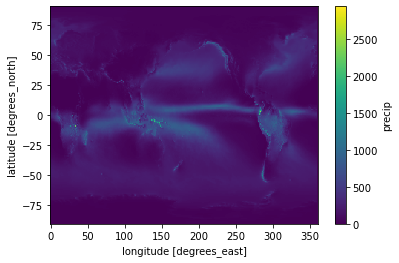

In [17]:
djf_verif.plot()

### get the EEZ

In [33]:
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'

In [34]:
EEZs, EEZ_merged = geo.get_EEZs(dpath_shapes=dpath_shapes)

### get the admin boundaries 

In [50]:
dpath_admin = pathlib.Path(HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries')) 

In [51]:
admin_areas = gpd.read_file(dpath_admin.joinpath("ICU_Sub_bound.shp"))

<AxesSubplot:>

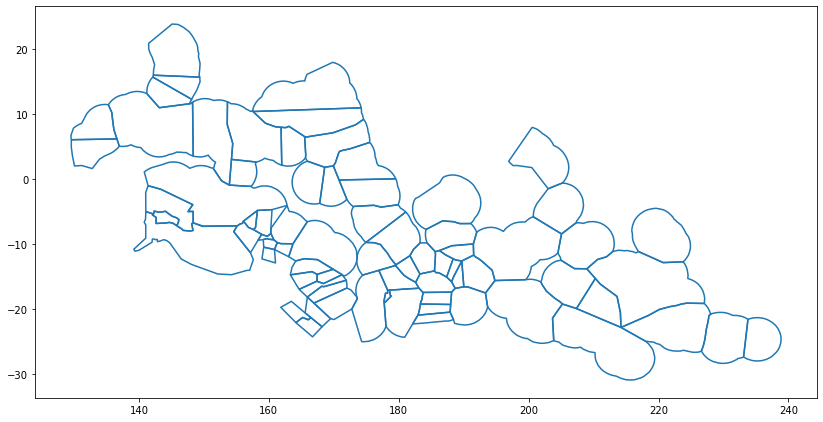

In [52]:
admin_areas.boundary.plot(figsize=(14,8))

In [70]:
admin_areas = admin_areas.replace({'Country':{'Paua New Guinea':'Papua New Guinea'}})

In [73]:
country_name = 'Papua New Guinea'
admin_name = 'Islands Region'

In [76]:
admin_areas.query(f"Country == '{country_name}'")

,id,Country,Admin_boun,geometry
50,54,Papua New Guinea,Islands Region,"POLYGON ((141.39512 -1.06547, 140.80937 1.0341..."
51,55,Papua New Guinea,Momase Region,"POLYGON ((141.39512 -1.06547, 143.34515 -1.614..."
52,56,Papua New Guinea,Highlands Region,"POLYGON ((142.06143 -5.36657, 142.25893 -5.391..."
53,57,Papua New Guinea,Southern Region,"POLYGON ((141.04927 -5.04564, 142.06143 -5.366..."


In [81]:
png_islands = admin_areas.query(f"Country == '{country_name}'").query(f"Admin_boun == '{admin_name}'")

### make the map 

In [19]:
cmap = plt.cm.Blues

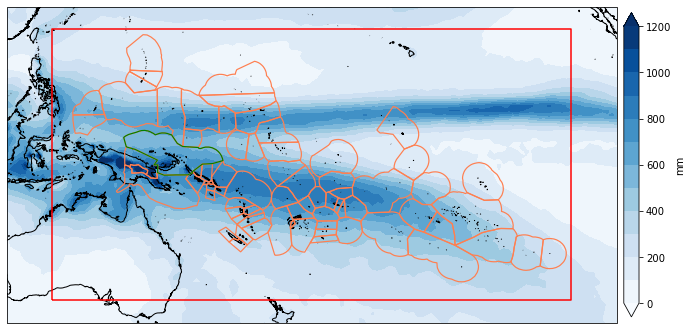

In [82]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(13,8))
        
lonmin, lonmax, latmin, latmax = domains.domains[domain_name]

shape = geo.gpd_from_domain(lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)

shape.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='r')

ax.coastlines(resolution='10m')

im = ax.contourf(djf_verif.lon.data, djf_verif.lat.data, djf_verif, levels=np.arange(0, 1250, 100), transform=ccrs.PlateCarree(), cmap=cmap, extend='both')

plt.colorbar(im, shrink=0.7, label='mm', pad=0.01)

# EEZs.boundary.plot(ax=ax, color='0.8', transform=ccrs.PlateCarree())

admin_areas.boundary.plot(ax=ax, color='coral', transform=ccrs.PlateCarree(), linewidths=1.2)

png_islands.boundary.plot(ax=ax, color='g', transform=ccrs.PlateCarree(), linewidths=1.2)

ax.set_extent([lonmin-10, lonmax+10, latmin-5, latmax+5], crs=ccrs.PlateCarree())

f.savefig('./figures_paper/study_domain.png', dpi=200, bbox_inches='tight', facecolor='w')
f.savefig('./figures_paper/study_domain.pdf', bbox_inches='tight', facecolor='w')